In [4]:
# Basic lib imports
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

In [5]:
#AAL atlas paths
AAL_LEFT = '/opt/quarantine/CIVET/1.1.12/build/CIVET-1.1.12/models/AAL_atlas_left.txt'
AAL_RIGHT = '/opt/quarantine/CIVET/1.1.12/build/CIVET-1.1.12/models/AAL_atlas_right.txt'
AAL_roi_names = '/home/cic/bhanik/Downloads/AAL_ROI_names_number_map.txt'

AAL_lowres_threshold = 40962

In [15]:
# Return mean thickness per ROI for a given subject-vertex data
def apply_atlas(atlas_data,sub_data):
    assert len(atlas_data) == len(sub_data)
    label_set = np.unique(atlas_data)
    
    # mask subject data with atlas
    sub_roi_dict = {}
    for label in label_set:
        sub_roi_dist = sub_data[atlas_data==label]
        sub_roi_dict[label] = np.mean(sub_roi_dist)
        
    return sub_roi_dict

def get_cohort_data(subject_dir,atlas_data,cohort_naming_string):
    label_set = np.unique(atlas_data)
    print('# of unique labels: {}, max label: {}, min label: {}'.format(len(label_set),np.max(atlas_data),np.min(atlas_data)))

    subject_ids = os.listdir(subject_dir)
    print('Number of subjects: {}'.format(len(subject_ids)))

    cohort_df = pd.DataFrame(columns=['Subject_ID']+list(label_set))
    for sub_id in subject_ids:
        sub_file = '{}/thickness/{}'.format(sub_id, cohort_naming_string).format(sub_id)
        sub_data = pd.read_csv(subject_dir + sub_file,header=None).values
        sub_roi_dict = apply_atlas(atlas_data,sub_data)
        sub_df =  pd.DataFrame([sub_roi_dict], columns=list(sub_roi_dict.keys()))
        sub_df['Subject_ID'] = [sub_id]
        cohort_df = cohort_df.append(sub_df,ignore_index=True)
    
    print('Dataframe size {}'.format(cohort_df.shape))
    return cohort_df


In [40]:
# Read atlas file   
atlas_data_L = pd.read_csv(AAL_LEFT,header=None).values[:AAL_lowres_threshold]
atlas_data_R = pd.read_csv(AAL_RIGHT,header=None).values[:AAL_lowres_threshold]

# Read subject file
#subject_dir = '/data/chamal/projects/nikhil/data/ASD_ML/data/armin_data/civet_out/mallar_all/'
subject_dir = '/data/chamal/projects/nikhil/data/my_scans/vertex_to_roi_input/'

cohort_naming_string = 'HA_1002_native_rms_tlink_20mm_left.txt'
subject_aal_L = get_cohort_data(subject_dir,atlas_data_L,cohort_naming_string)

cohort_naming_string = 'HA_1002_native_rms_tlink_20mm_right.txt'
subject_aal_R = get_cohort_data(subject_dir,atlas_data_R,cohort_naming_string)

subject_data = pd.merge(subject_aal_L,subject_aal_R,on='Subject_ID')


# of unique labels: 40, max label: 89, min label: 0
Number of subjects: 2
Dataframe size (2, 41)
# of unique labels: 40, max label: 90, min label: 0
Number of subjects: 2
Dataframe size (2, 41)


/data/chamal/projects/nikhil/code/python/conda/anaconda2/envs/tensorflow_v14/lib/python3.5/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [41]:
# Map the ROI Ids and names
aal_roi_names = pd.read_csv(AAL_roi_names,delimiter='\'',header=None)
aal_roi_names = aal_roi_names[[0,1,3]]
aal_roi_names.columns = ['id','roi','name']
aal_roi_names['roi'] = aal_roi_names['roi']+'_CT'
aal_roi_names_dict = dict(zip(aal_roi_names['id'], aal_roi_names['roi']))
aal_roi_names_dict['0_x'] = 'background_L'
aal_roi_names_dict['0_y'] = 'background_R'
subject_data = subject_data.rename(columns=aal_roi_names_dict)
subject_data.to_csv('/data/chamal/projects/nikhil/data/ASD_ML/data/armin_data/csv/vertex_to_aal.csv')

In [42]:
subject_data

,Subject_ID,background_L,PreCG.L_CT,SFGdor.L_CT,ORBsup.L_CT,MFG.L_CT,ORBmid.L_CT,IFGoperc.L_CT,IFGtriang.L_CT,ORBinf.L_CT,...,SMG.R_CT,ANG.R_CT,PCUN.R_CT,PCL.R_CT,HES.R_CT,STG.R_CT,TPOsup.R_CT,MTG.R_CT,TPOmid.R_CT,ITG.R_CT
0,nb_bl,2.496778,2.852956,3.04281,2.994912,3.065666,2.939406,3.283206,2.954178,3.248627,...,2.719637,2.936455,3.031670,2.440382,2.882782,3.010262,3.140785,2.945882,2.568063,2.887281
1,nb_fu,2.842756,3.079399,3.33008,3.580564,3.376726,3.349346,3.551316,3.221660,3.676003,...,3.229529,3.322919,3.290381,2.628722,3.312307,3.388237,4.255294,3.405249,4.122778,3.688713


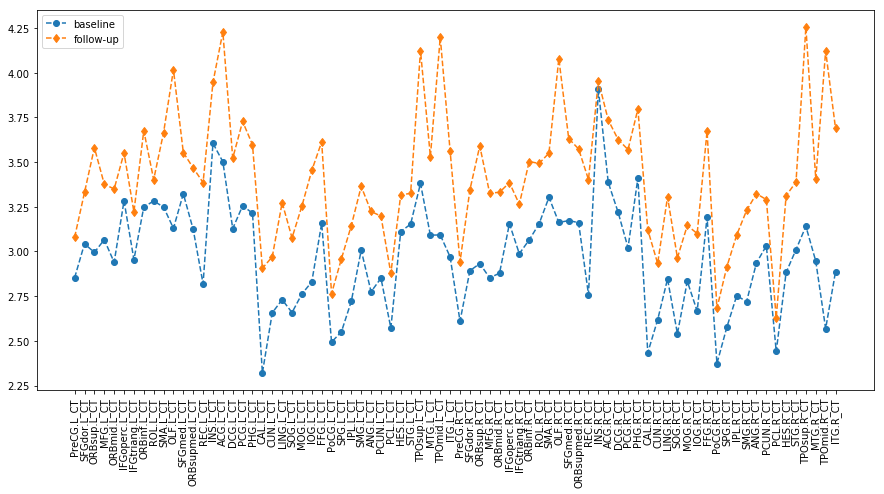

In [61]:
#plots
ct_cols = list(subject_data.columns[pd.Series(subject_data.columns).str.contains('CT')])
plt.figure(figsize=(15,7))
plt.plot(subject_data[ct_cols].values[0,:],'--o',label = 'baseline')
plt.plot(subject_data[ct_cols].values[1,:],'--d',label = 'follow-up')
plt.legend()
plt.xticks(range(78),ct_cols,rotation='vertical');
# g = sns.pointplot(data=subject_data[ct_cols])
# g.set_xticklabels(rotation=90)  